<a href="https://colab.research.google.com/github/petitmeau/Python-VMP/blob/main/Project_Stanford.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Cord blood donation and delay cord clamping

Cord blood donation is a life-saving treatment. Blood is collected from the cord and the placenta at birth, instead of being thrown away. This blood contains a high concentration of stem cells, which can be used to treat children and adults requiring stem cells or bone marrow transplant and for whom no donor has been identified.

The Hopital Franco-britannique proposes cord blood donation to all pregnant women, followed at its institution.

On the other hand, the French neonatal society (SFN) recommends delayed cord clamping (DCC) between 30 and 60sec after birth for stable term bablies, to optimize iron status and prevent late anemia.


Aim of my project was to answer the following questions:
* Is our practice consistent withe SFN recommendation?
* Does DCC impact CBD (DVSC in French)?
* Are there some maternal factors impacting the volume of blood collected?
* Can we build a model, which would allow us to flag women with best chances to provide maximum amount of blood?

For tis, I have collected data over 1 month and 19 days at the HFB, from all deliveries. Data were collected on an excel document.
My program imported the data in 1 line of code allowing all subsequent analysis with python.

In [ ]:
# Download of the required modules

from google.colab import drive
drive.mount("/content/drive")

%matplotlib inline
from bokeh.io import output_notebook
from bokeh import models, palettes, transform
from bokeh.plotting import figure, show
import numpy as np
import pandas as pd
import pydotplus


import matplotlib.pyplot as plt

import seaborn as sns
from sklearn import cluster, decomposition, pipeline, preprocessing, tree
import statsmodels

from yellowbrick.cluster.silhouette import SilhouetteVisualizer
from scipy.cluster import hierarchy
from scipy.cluster.hierarchy import dendrogram, linkage

#import fancyimpute
import missingno as mn

import io
import urllib.request as req
import zipfile



Mounted at /content/drive


In [ ]:
# File download
filename = '/content/drive/My Drive/DVSC_et_DCC/DVSC/07122023DCC_et_DVSC.xlsx'

#headers = ['Cas_Naccht','Ethnicite', 'Age_maternel', 'Parite', 'Perc_Echo_T3', 'Declenchement', 'Duree du travail (heures completes)', 'OPDE','DEE', 'ARCF', 'Circulaire du cordon','Voie d\'accouchement','AG', 'PN', 'Sexe', 'pH cordon', 'Lactates_cordon', 'DCC', 'DVSC', 'Poids_poche']

df=pd.read_excel(filename)


NameError: name 'pd' is not defined

In [ ]:
df.head()

,Unnamed: 0,Cas_Naccht,Ethnicite,Age maternel,Parite,Perc_Echo_T3,Declenchement,Duree du travail (heures completes),OPDE,DEE,...,Voie d'accouchement,AG,PN,Sexe,pH cordon,Lactates_cordon,DCC,DVSC,Poids_poche,Unnamed: 21
0,0,452,1,35,3,36.0,2,5,0.0,2.0,...,1,39.0,3168.0,1.0,7.34,2.4,86.0,1.0,133.0,NaN
1,1,453,5,19,1,72.0,2,0,1.0,0.0,...,2,39.0,3576.0,2.0,7.16,3.8,75.0,2.0,NaN,NaN
2,2,454,5,33,3,66.0,2,11,11.0,1.0,...,1,39.0,3484.0,2.0,7.36,2.9,45.0,1.0,129.0,NaN
3,3,455,2,42,2,60.0,2,1,26.0,1.0,...,1,39.0,3058.0,1.0,7.35,1.6,NaN,2.0,NaN,NaN
4,4,456,1,36,3,76.0,2,15,48.0,53.0,...,1,39.0,3422.0,1.0,7.33,3.8,120.0,2.0,NaN,NaN


In [ ]:
#This will show you all data collected
df.info()

NameError: name 'df' is not defined

##First question: is our practice of DCC consistent with the SFN recommendation?

In [ ]:
df.DCC.describe()


count    109.000000
mean      55.724771
std       30.639744
min        1.000000
25%       32.000000
50%       55.000000
75%       70.000000
max      163.000000
Name: DCC, dtype: float64

Mean DCC is 56 sec, within the required range. How are the data spread?

In [ ]:
# First, I removed NaN data.
df.DCC.dropna()



0       86.0
1       75.0
2       45.0
4      120.0
5       35.0
       ...  
257     60.0
269     10.0
279     15.0
281      1.0
289      1.0
Name: DCC, Length: 109, dtype: float64

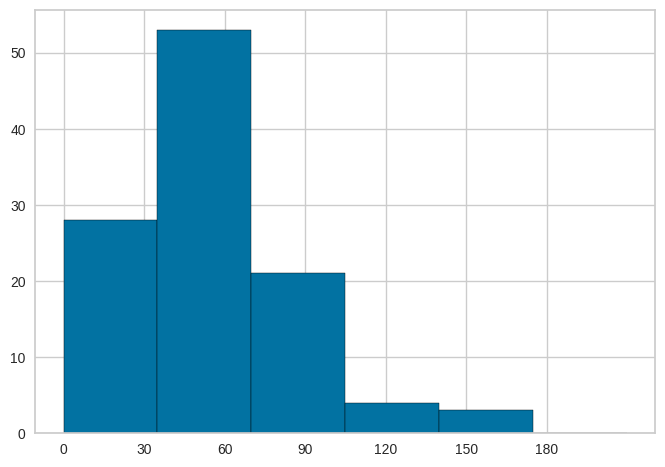

In [ ]:
# Then I grouped them by bins of 30 sec

plt.hist(df.DCC, np.linspace(0, 210,7), histtype="bar", ec="black")

plt.xticks(np.arange(0, 210, 30), fontsize=10)
plt.yticks(fontsize=10 )

plt.show()


In [ ]:
df_short =df[df['DCC']<30]
df_short['Voie d\'accouchement'].value_counts()
#df_short['Voie d\'accouchement']

Voie d'accouchement
1    12
3     8
2     1
Name: count, dtype: int64

In [ ]:
df['Voie d\'accouchement'].value_counts()


Voie d'accouchement
1    245
3     31
2     25
Name: count, dtype: int64

In [ ]:
df_short

,Unnamed: 0,Cas_Naccht,Ethnicite,Age maternel,Parite,Perc_Echo_T3,Declenchement,Duree du travail (heures completes),OPDE,DEE,...,AG,PN,Sexe,pH cordon,Lactates_cordon,DCC,DVSC,Poids poche,Unnamed: 21,DCC_bins
28,28,480,5,33,1,42.0,2,7,4.0,41.0,...,39.0,2824.0,1.0,7.33,3.8,20.0,2.0,NaN,NaN,"(0, 30]"
43,43,495,1,38,1,63.0,2,6,29.0,35.0,...,39.0,3516.0,1.0,7.25,4.8,26.0,1.0,147.0,NaN,"(0, 30]"
61,61,513,5,27,1,80.0,2,21,17.0,28.0,...,41.0,4280.0,2.0,7.27,4.5,27.0,2.0,NaN,NaN,"(0, 30]"
68,68,520,5,36,2,94.0,2,0,0.0,0.0,...,39.0,3174.0,1.0,7.28,2.7,29.0,2.0,NaN,NaN,"(0, 30]"
76,76,528,5,25,1,38.0,2,21,15.0,0.0,...,40.0,2634.0,1.0,7.26,6.2,20.0,2.0,NaN,NaN,"(0, 30]"
82,82,534,4,30,1,84.0,2,12,6.0,0.0,...,40.0,3674.0,1.0,7.26,4.8,18.0,1.0,181.0,NaN,"(0, 30]"
83,83,535,1,37,2,68.0,2,11,5.0,2.0,...,41.0,3824.0,2.0,7.34,2.8,26.0,1.0,162.0,NaN,"(0, 30]"
95,95,547,1,38,1,46.0,2,11,83.0,0.0,...,41.0,4185.0,2.0,7.29,2.1,29.0,2.0,NaN,NaN,"(0, 30]"
126,126,578,5,35,1,77.0,1,3,0.0,0.0,...,40.0,3074.0,1.0,7.23,6.3,20.0,2.0,NaN,NaN,"(0, 30]"
136,136,588,1,38,2,50.0,2,5,2.0,5.0,...,40.0,3346.0,2.0,7.17,6.6,10.0,2.0,NaN,NaN,"(0, 30]"


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 301 entries, 0 to 300
Data columns (total 22 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   Unnamed: 0                           301 non-null    int64  
 1   Cas_Naccht                           301 non-null    int64  
 2   Ethnicite                            301 non-null    int64  
 3   Age maternel                         301 non-null    int64  
 4   Parite                               301 non-null    int64  
 5   Perc_Echo_T3                         296 non-null    float64
 6   Declenchement                        301 non-null    int64  
 7   Duree du travail (heures completes)  301 non-null    int64  
 8   OPDE                                 300 non-null    float64
 9   DEE                                  293 non-null    float64
 10  ARCF                                 300 non-null    float64
 11  Circcordon                      

<Axes: >

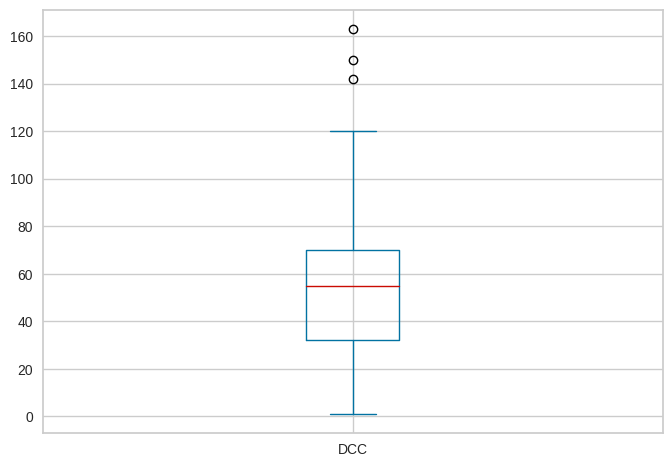

In [ ]:
# another way to look at it with boxplot
df.DCC.plot.box()

##So most of the babies born term and stable at our institution have a DCC between 30sec and 60 sec. Let's get the numbers


In [ ]:
df['DCC_bins']= pd.cut(df.DCC, bins = np.arange(0,180, 30))
df.DCC_bins.value_counts()

DCC_bins
(30, 60]      42
(60, 90]      30
(0, 30]       26
(90, 120]      8
(120, 150]     2
Name: count, dtype: int64

##Second question: Does DCC impact CBD (DVSC in French)?
One way to look at it, is to extract a heatmap which whill show correlation between DCC and all studied factors. Looking at colors is far much powerful  than absolute numbers to me!
**Here we are looking at DCC and 'Poids_poche', which means weight of the blood collected**


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 301 entries, 0 to 300
Data columns (total 22 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   Unnamed: 0                           301 non-null    int64  
 1   Cas_Naccht                           301 non-null    int64  
 2   Ethnicite                            301 non-null    int64  
 3   Age maternel                         301 non-null    int64  
 4   Parite                               301 non-null    int64  
 5   Perc_Echo_T3                         296 non-null    float64
 6   Declenchement                        301 non-null    int64  
 7   Duree du travail (heures completes)  301 non-null    int64  
 8   OPDE                                 300 non-null    float64
 9   DEE                                  293 non-null    float64
 10  ARCF                                 300 non-null    float64
 11  Circcordon                      

ValueError: could not convert string to float: 'Poids poche'

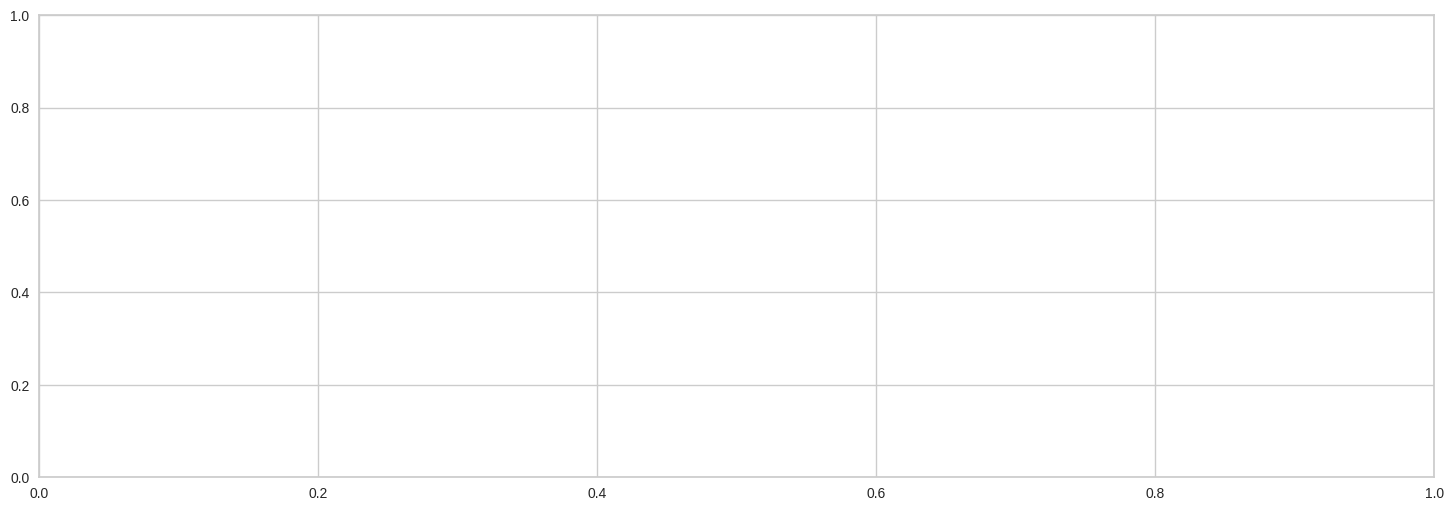

In [ ]:
# Second question: Does DCC impact CBD (DVSC in French)?
fig, ax = plt.subplots(figsize=(18, 6))
sns.heatmap(df.corr(), annot=True, cmap='RdBu', vmin=-1, vmax=1)

Well, the correlation is -0,33, dark orange color on the heatmap....
Can we see the linear correlation?


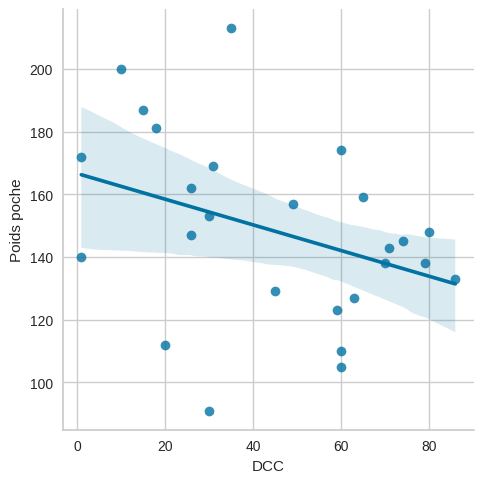

In [ ]:
sns.lmplot(x='DCC', y='Poids poche', data=df)

Nice! But we definitely need more data as many point are far from the linear regression line...
Wht if we increase the accuracy by modeling as a second degree polynomial non linear-regression?

(<seaborn.axisgrid.FacetGrid at 0x7ae2c0598730>,)

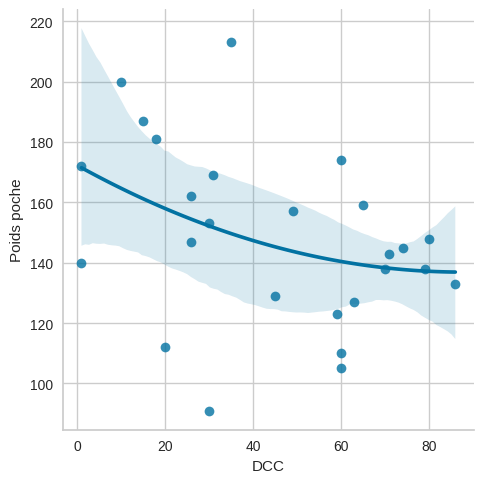

In [ ]:
sns.lmplot(x='DCC', y='Poids poche', data=df, fit_reg=True, order=2),

This is so interesting! It seems that after 60 sec, the weight of blood collected does not decrease a lot... I definitely need more data...

#Third, are there some maternal factors impacting the volume of blood collected?

<ipython-input-40-3f1a2f17f7e8>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1_noDCC.dropna(inplace=True)


<Axes: >

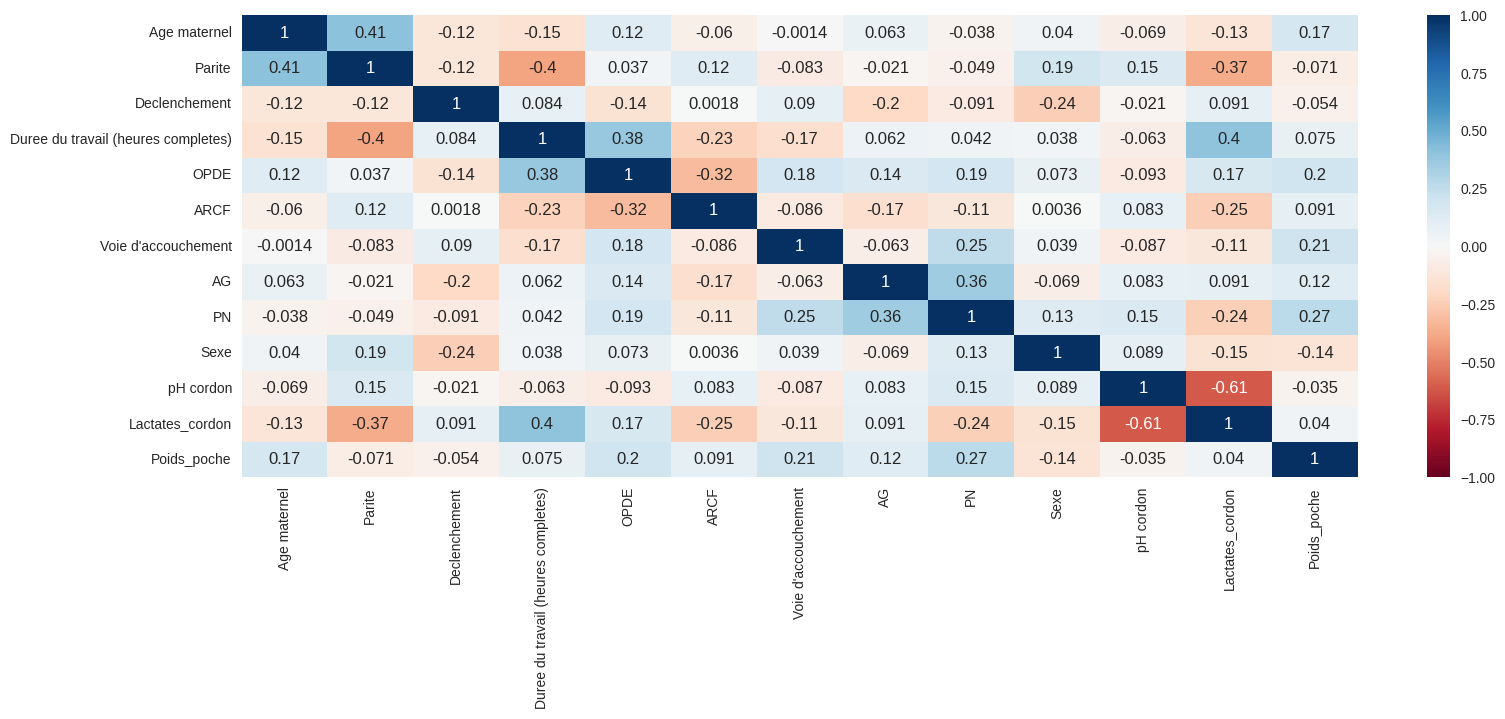

In [ ]:
#Let's extract only the columns I need to analyze abd remove the DCC data. Let's see which factors impact the amount of blood collected using my heatmap again
df1= df[['Age maternel', 'Parite', 'Declenchement', 'Duree du travail (heures completes)', 'OPDE', 'ARCF','Voie d\'accouchement','AG', 'PN', 'Sexe', 'pH cordon', 'Lactates_cordon', 'DCC', 'Poids_poche']]
df1_noDCC = df[['Age maternel', 'Parite', 'Declenchement', 'Duree du travail (heures completes)', 'OPDE', 'ARCF','Voie d\'accouchement','AG', 'PN', 'Sexe', 'pH cordon', 'Lactates_cordon', 'Poids_poche']]
df1_noDCC.dropna(inplace=True)
fig, ax = plt.subplots(figsize=(18, 6))
sns.heatmap(df1_noDCC.corr(), annot=True, cmap='RdBu', vmin=-1, vmax=1)


In [ ]:
!pip install networkx

In [ ]:
import networkx as nx

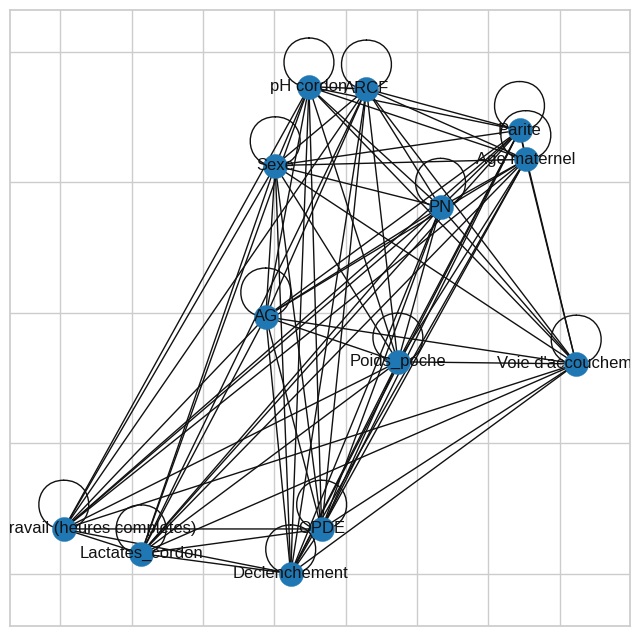

In [ ]:
G = nx.Graph(df1_noDCC.corr())

figure = plt.figure(figsize = (8,8))
nx.draw_networkx(G, with_labels = True)


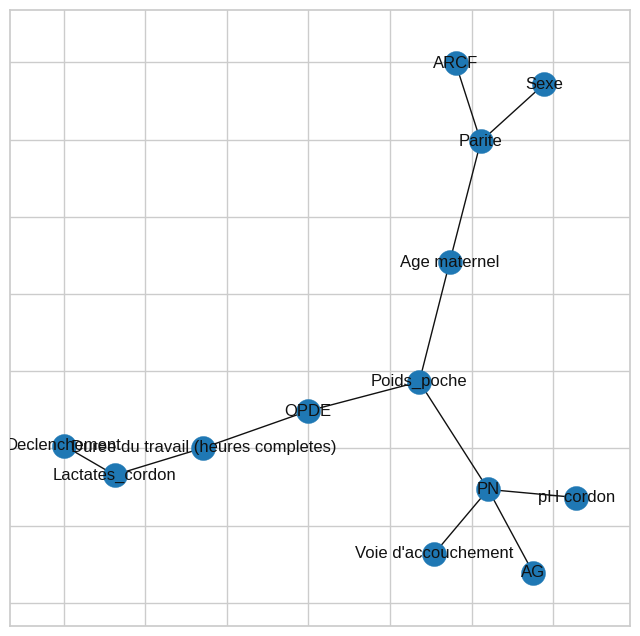

In [ ]:
#filter usinf the MST tree
distance = np.sqrt(2*(1-df1_noDCC.corr()))
distance_graph = nx.Graph(distance)
graph_filtered = nx.minimum_spanning_tree(distance_graph)
figure = plt.figure(figsize = (8,8))
nx.draw_networkx(graph_filtered, with_labels = True)


So, duration of membranes opening ('OPDE'), mode of delivery ('Voie d'accouchement'), birth weight ('PN') seem to impact the weight of blood collected...let's have a deeper look into this...

<Axes: xlabel='Parite', ylabel='Poids poche'>

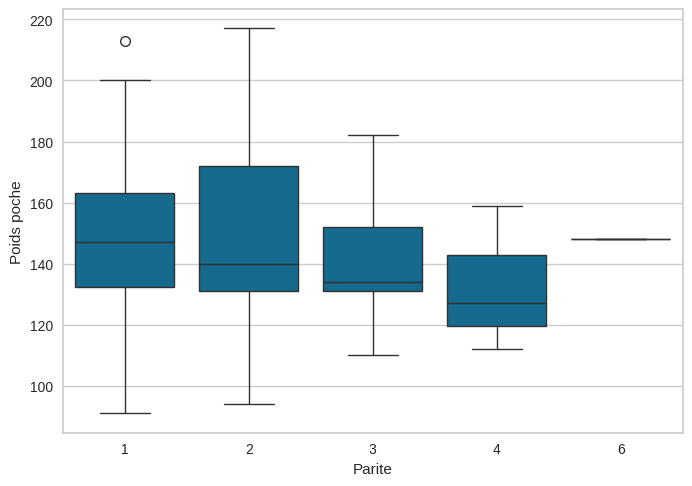

In [ ]:
# for my personnal interest I wanted to explore also the role of parity
sns.boxplot(x='Parite', y='Poids poche', data = df1_noDCC)

This needs to be further explored... amount of blood collected seems to decrease with parity, but there are only few 4th pare....

In [ ]:
df1_noDCC.Parite.value_counts()

1    35
2    29
3     7
4     3
6     1
Name: Parite, dtype: int64

Only 3 of them, so definitely too soon to draw any conclusion on this

<Axes: xlabel="Voie d'accouchement", ylabel='Poids poche'>

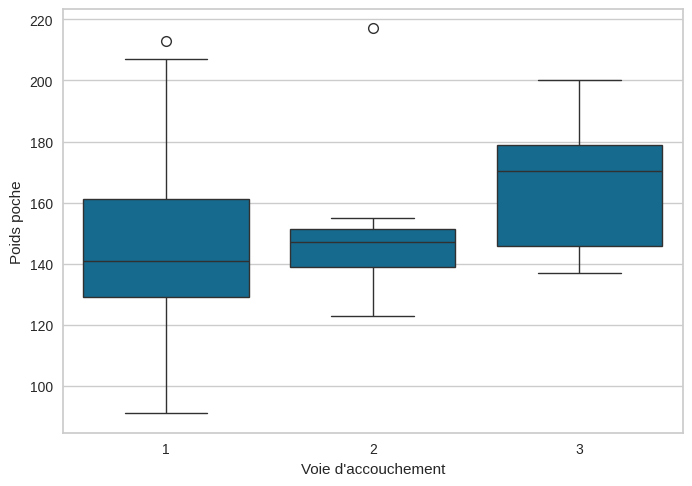

In [ ]:
#What about the mode of delivery
sns.boxplot(x='Voie d\'accouchement', y='Poids poche', data = df1_noDCC)

1 is vaginal delivery, 2 is planned C-section and 3 is emergency C-section
It seems that more blood is collected from urgent C-section. When I asked the question to the specialist midwife, she told me that unfortunately this doesnot correlate with the number of T -cells available...another factor to add and study!

In [ ]:
df1_noDCC['Voie d\'accouchement'].value_counts()

1    62
2     7
3     6
Name: Voie d'accouchement, dtype: int64

And only 3 women delivered by urgent C-section... some again, more data are needed!

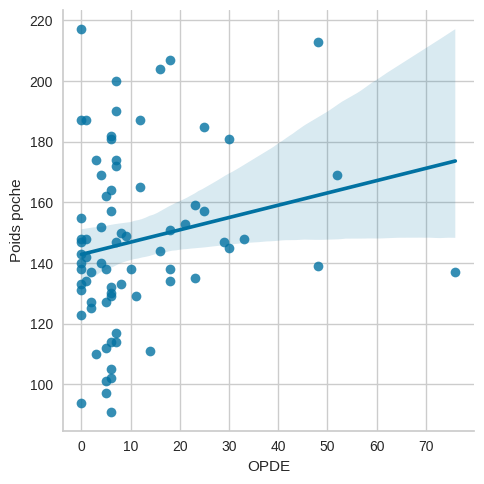

In [ ]:
#What about duration of membranes opening?
sns.lmplot(x='OPDE', y='Poids poche', data = df1_noDCC)

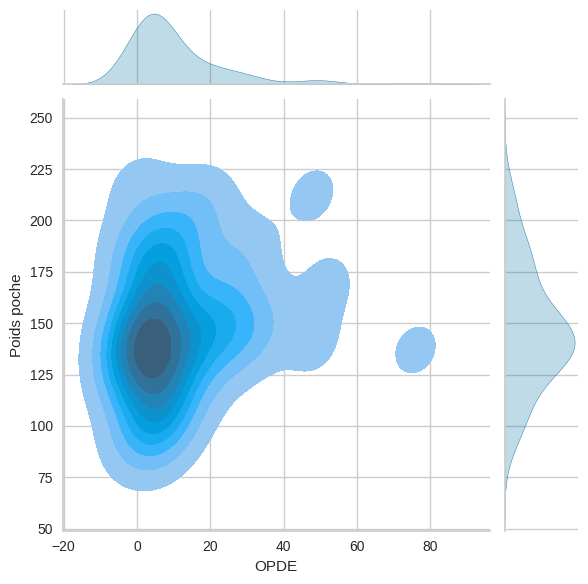

In [ ]:
sns.jointplot(data = df1_noDCC,x='OPDE', y='Poids poche', kind="kde", fill=True )

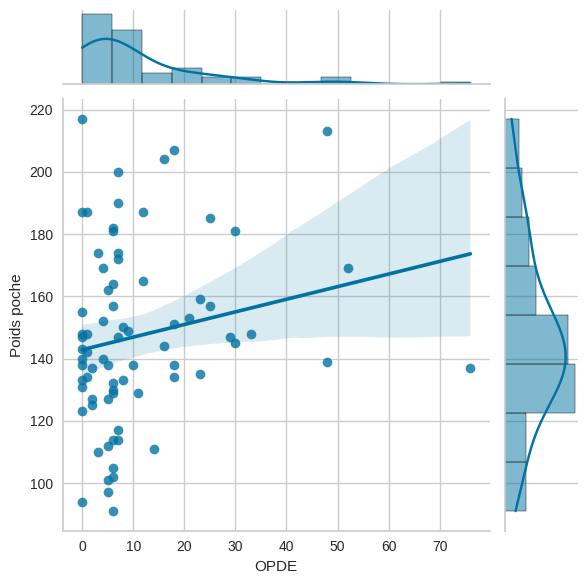

In [ ]:
sns.jointplot(data = df1_noDCC,x='OPDE', y='Poids poche', kind="reg" )

Nice correlation... and again let's modelize with non linear order 2 regression model...


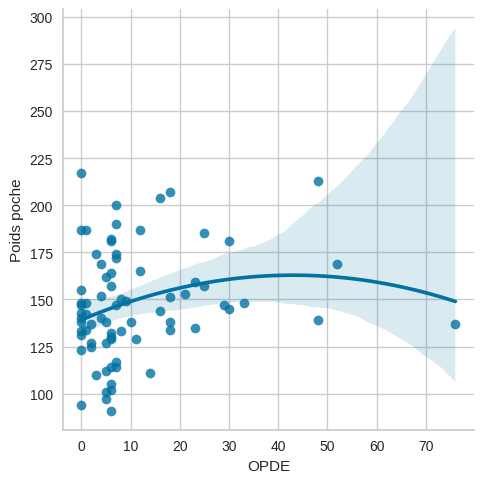

In [ ]:
sns.lmplot(x='OPDE', y='Poids poche', data = df1_noDCC, fit_reg=True, order=2)

It seems there is some benefit until 25-30h of opening, then no more, but data are more scarce of course after such a long amount of time

<ipython-input-36-efddbcb8d6a4>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1_noDCC['OPDE_bin']= pd.cut(x=df1_noDCC['OPDE'], bins = [0,6,12, 18, 24, 48, 72])


<Axes: xlabel='OPDE_bin', ylabel='Poids poche'>

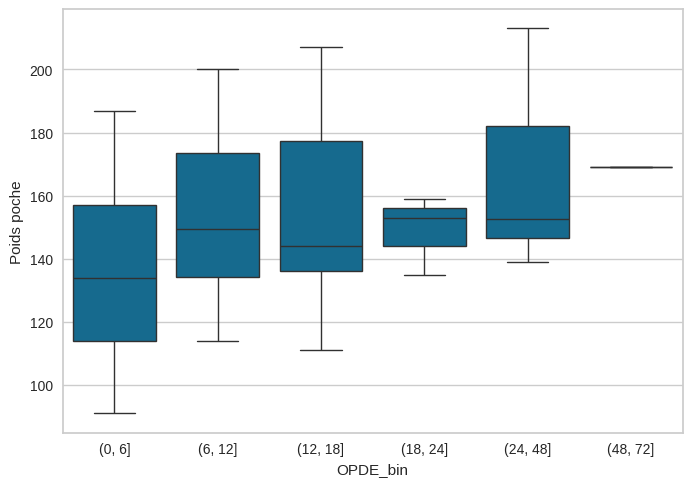

In [ ]:
#let's see when you startify by different time bins...
df1_noDCC['OPDE_bin']= pd.cut(x=df1_noDCC['OPDE'], bins = [0,6,12, 18, 24, 48, 72])
df2 = df1_noDCC[['Poids poche','OPDE_bin']]
df2.dropna()
df2.groupby(['OPDE_bin'])
#df2.groupby(['OPDE_bin']).boxplot('OPDE_bin')
sns.boxplot(x= 'OPDE_bin', y = 'Poids poche', data = df2)

Some increase amount of blood from 6h to 18 hours, then from 18 to 48. Maybe I should widen my bins?

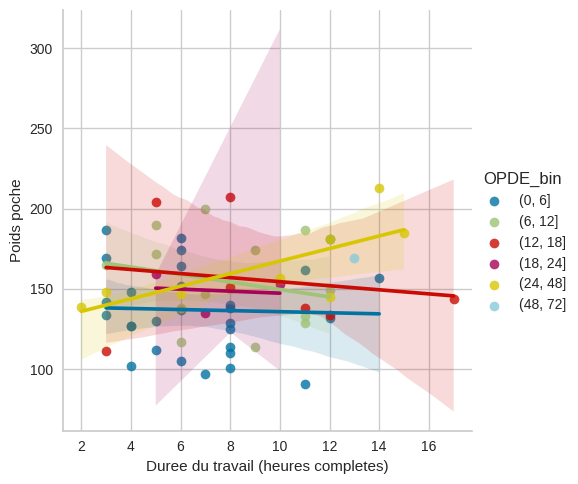

In [ ]:
# Now is there a correlation bewteen duration of membranes opening and labour duration? Maybe Labour duration is a confounding factor?
sns.lmplot(x='Duree du travail (heures completes)', y='Poids poche', hue = 'OPDE_bin', data = df1_noDCC)

It seems not!

#Last question: Can we build a model, which would allow us to flag women with best chances to provide maximum amount of blood?

In [ ]:
# Let's create the model first and standardize data
X = df1
std = preprocessing.StandardScaler()
X_std= pd.DataFrame(std.fit_transform(X), columns=X.columns)
X_std

,Age maternel,Parite,Declenchement,Duree du travail (heures completes),OPDE,ARCF,Voie d'accouchement,AG,PN,Sexe,pH cordon,Lactates_cordon,DCC,Poids poche
0,0.453639,1.606828,0.581187,-0.294100,-0.428470,0.833797,-0.450590,-0.503342,-0.558031,-0.980196,0.719355,-0.856984,0.992667,-0.500622
1,-3.139659,-0.758234,0.581187,-0.863752,-0.397406,0.833797,1.108347,-0.503342,0.466785,1.020204,-1.425601,-0.106920,0.631998,NaN
2,0.004477,1.606828,0.581187,0.389483,-0.086771,-1.167315,-0.450590,-0.503342,0.235699,1.020204,0.957683,-0.589104,-0.351645,-0.640722
3,2.025707,0.424297,0.581187,-0.749821,0.379182,0.833797,-0.450590,-0.503342,-0.834329,-0.980196,0.838519,-1.285591,NaN,NaN
4,0.678220,1.606828,0.581187,0.845205,1.062580,0.833797,-0.450590,-0.503342,0.079967,-0.980196,0.600190,-0.106920,2.107463,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
296,0.678220,1.606828,-1.720618,-0.180169,-0.242088,0.833797,-0.450590,-0.503342,1.516720,1.020204,-0.353123,-0.642680,NaN,1.215597
297,0.004477,-0.758234,0.581187,0.503414,-0.242088,0.833797,-0.450590,-0.503342,0.270865,1.020204,0.004369,0.214535,NaN,-0.535647
298,0.453639,-0.758234,0.581187,0.047692,-0.179961,-1.167315,-0.450590,0.408198,0.205558,-0.980196,-1.187273,2.143269,NaN,0.094801
299,-0.220104,0.424297,-1.720618,-0.521960,0.006420,0.833797,-0.450590,0.408198,0.331148,1.020204,0.361862,-0.803408,NaN,-1.271170


In [ ]:
X2 = df1_noDCC
X2.dropna()
X2.pop('OPDE_bin')
X2.dtypes
std = preprocessing.StandardScaler()
X2_std= pd.DataFrame(std.fit_transform(X2), columns=X2.columns)
X2_std


,Age maternel,Parite,Declenchement,Duree du travail (heures completes),OPDE,ARCF,Voie d'accouchement,AG,PN,Sexe,pH cordon,Lactates_cordon,Poids poche
0,0.362473,1.325061,0.479070,-0.422196,-0.798262,0.862662,-0.428729,-0.806743,-0.894274,-1.069045,0.681730,-0.959799,-0.500622
1,-0.241649,1.325061,0.479070,1.062088,0.000969,-1.159202,-0.428729,-0.806743,-0.046061,0.935414,0.923478,-0.681865,-0.640722
2,0.362473,-0.812134,-2.087377,1.804229,2.689291,-1.159202,-0.428729,0.334874,0.088150,-1.069045,-0.527011,0.818979,2.301368
3,-1.147832,-0.812134,0.479070,0.814707,0.727542,-1.159202,-0.428729,0.334874,-0.577536,-1.069045,2.253093,2.430997,0.199875
4,-0.543710,-0.812134,0.479070,1.062088,-0.362318,0.862662,-0.428729,-0.806743,0.018360,-1.069045,0.439982,0.096351,-1.971667
...,...,...,...,...,...,...,...,...,...,...,...,...,...
70,0.664534,1.325061,-2.087377,-0.174816,-0.362318,0.862662,-0.428729,-0.806743,1.322890,0.935414,-0.406137,-0.737452,1.215597
71,-0.241649,-0.812134,0.479070,1.309468,-0.362318,0.862662,-0.428729,-0.806743,-0.008482,0.935414,-0.043515,0.151937,-0.535647
72,0.362473,-0.812134,0.479070,0.319946,-0.217003,-1.159202,-0.428729,0.334874,-0.078272,-1.069045,-1.252255,2.153063,0.094801
73,-0.543710,0.256463,-2.087377,-0.916958,0.218941,0.862662,-0.428729,0.334874,0.055939,0.935414,0.319108,-0.904212,-1.271170


In [ ]:
#This is now the time to create Principle components analysis: all columns datas will be condensed within one column. Many PCs will be created with decreasing variance. The bigger the variance is, the more information you get from yoru PC.
#So the first columns with greater variances will be the most interesting
pca=decomposition.PCA()
pca_X2 = pd.DataFrame(pca.fit_transform(X2_std))
pca_X2

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,-1.883878,-1.458805,0.213136,0.376047,-0.479547,0.941595,0.636521,0.324792,0.419788,-0.146580,-0.204736,0.599049,-0.022574
1,-0.605721,0.059564,0.290189,-1.449447,1.262929,1.308612,0.682173,-0.362640,-0.186627,-0.567358,0.575664,0.873798,-0.209757
2,2.858607,2.575778,1.045476,0.116742,-0.975537,-0.482458,1.647849,2.076257,-0.133693,-0.636632,0.097093,-0.097365,-0.324085
3,2.213520,-0.289103,-0.904678,-1.123032,-0.737520,1.361722,0.503513,1.032598,0.104796,0.569015,1.525365,-0.071317,2.023461
4,0.447643,-1.785991,-0.917791,-0.991518,0.064200,0.502650,0.286742,0.204854,0.526177,-0.053970,-1.699534,0.413577,0.566178
...,...,...,...,...,...,...,...,...,...,...,...,...,...
70,-1.712342,1.385265,0.911212,0.134822,-0.120615,-1.976337,0.744383,-0.078530,-0.458228,-1.476806,-0.183312,0.705365,0.065845
71,0.513316,-0.961322,-0.430889,-0.887331,0.738642,-0.647489,1.030407,-0.851738,-0.296473,0.190628,-0.714472,0.104876,0.029186
72,2.521429,-0.588345,0.740832,0.639986,-0.868125,0.444446,-0.831666,-0.345238,-0.558578,-0.336725,0.074986,-0.008591,0.562245
73,-1.645747,0.291594,0.412971,-1.606546,0.098334,-1.461024,-0.782573,0.894518,0.710011,0.046060,-0.530096,-0.409089,-0.066106


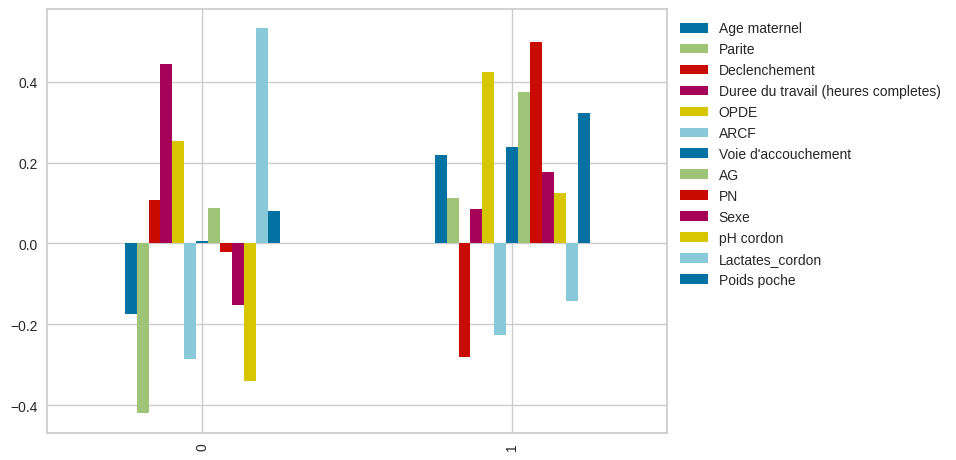

In [ ]:
#what columns make up the principle components 1 and 2?
#PC1 and PC2
pd.DataFrame(pca.components_, columns=X2_std.columns).iloc[:2].plot.bar().legend(bbox_to_anchor=(1,1))

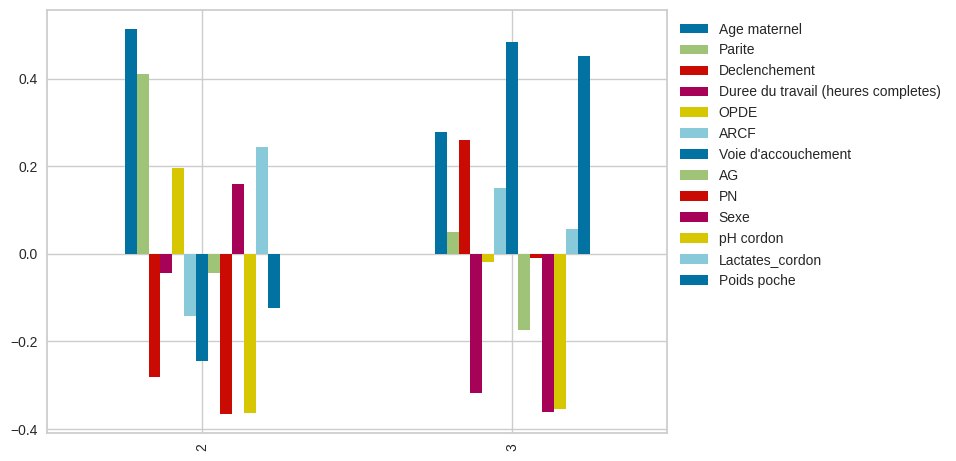

In [ ]:
#PC 2 and 3:
pd.DataFrame(pca.components_, columns=X2_std.columns).iloc[2:4].plot.bar().legend(bbox_to_anchor=(1,1))

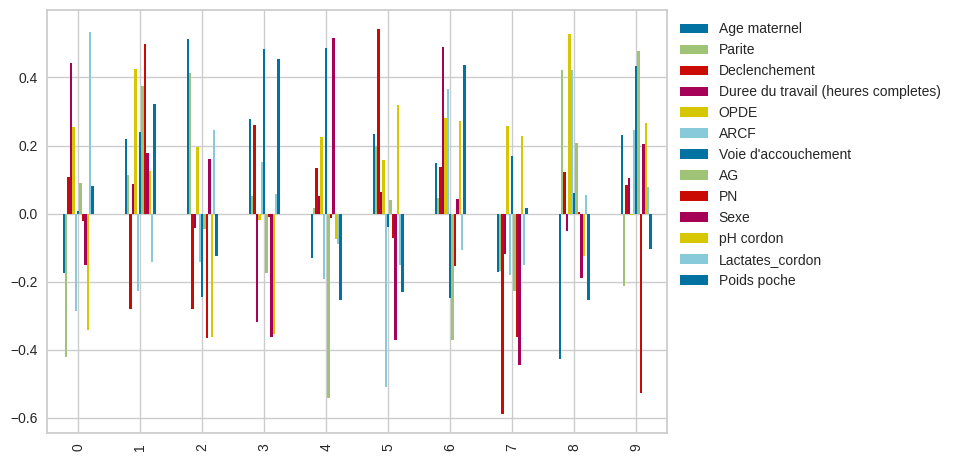

In [ ]:
# And if we include all PCs?
pd.DataFrame(pca.components_, columns=X2_std.columns).iloc[:10].plot.bar().legend(bbox_to_anchor=(1,1))

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

<Axes: >

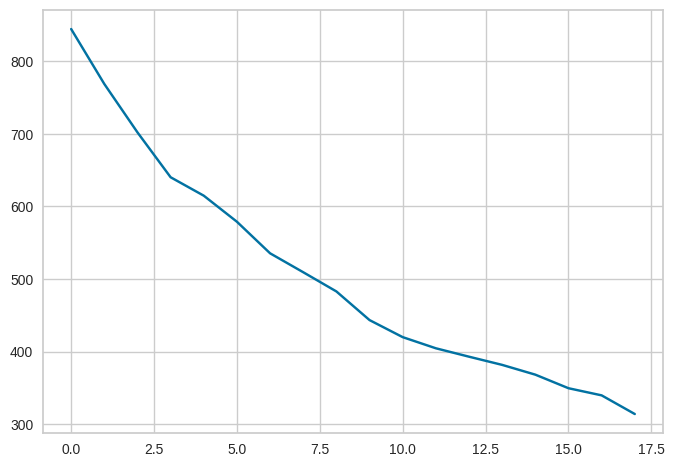

In [ ]:
# Now I want to create clusters of PCs. I will use the Elbow method to suggest how many clusters can be created
inerts = []
for i in range(2, 20):
    k = cluster.KMeans(n_clusters=i, random_state=42)
    k.fit(X2_std)
    inerts.append(k.inertia_)

pd.Series(inerts).plot()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

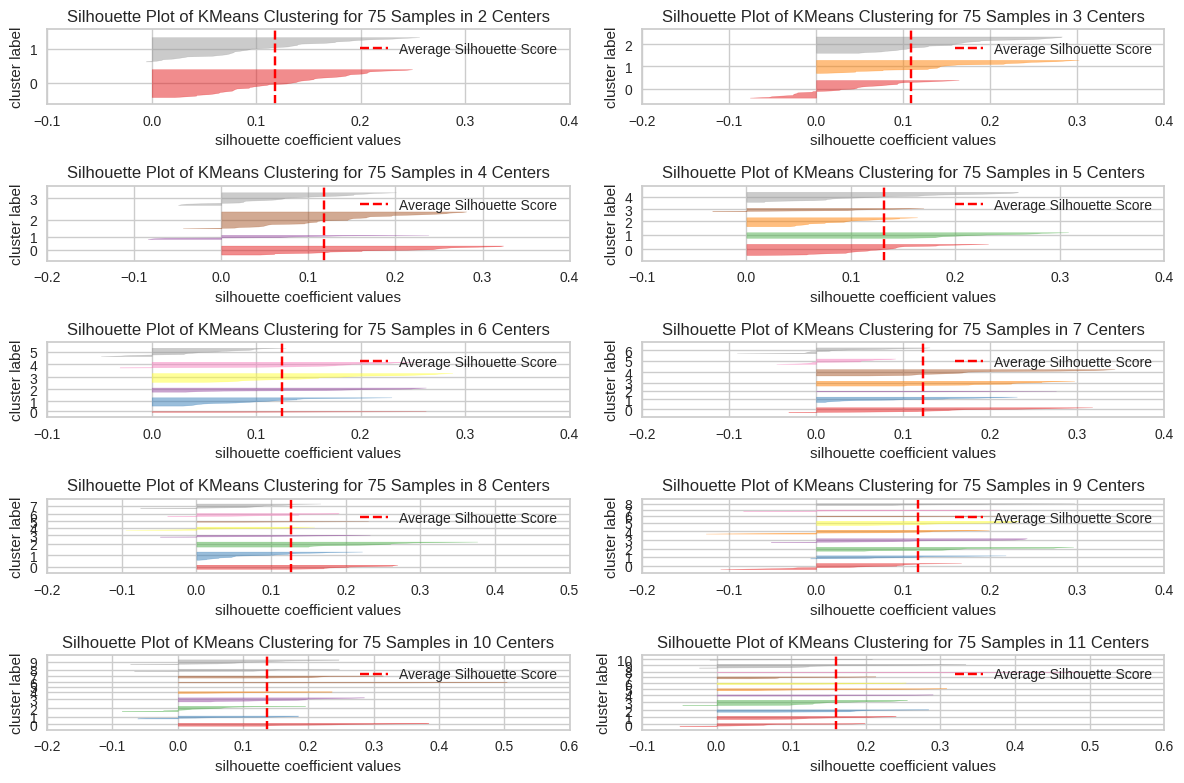

In [ ]:
# Trying ot find the optimal number of clusters using the silhouette visualizer method
start, end = 2, 12
cols = 2
rows = ((end - start) // cols)
fix, axes = plt.subplots(rows, cols, figsize=(12,8))
axes = axes.reshape(cols * rows)
for i, k in enumerate(range(start, end), 0):
    ax = axes[i]
    sil = SilhouetteVisualizer(cluster.KMeans(n_clusters=k, random_state=42), ax=ax)
    sil.fit(X2_std)
    sil.finalize()
plt.tight_layout()

OK, so 4 or 6 clusters seem to be the good number. Let's see with another method

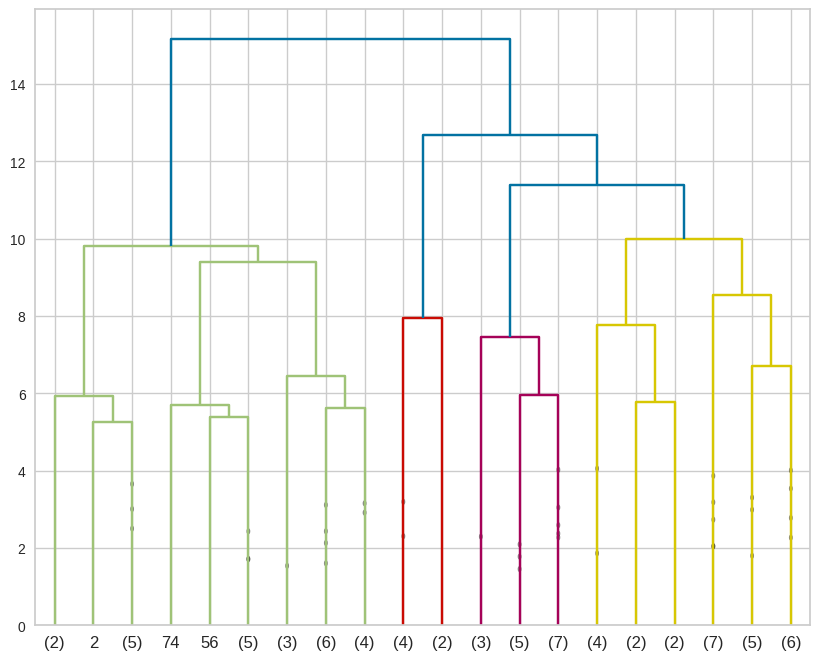

In [ ]:
# Try another mechanism: the dendogram
fig, ax = plt.subplots(figsize=(10,8))
hierarchy.dendrogram(hierarchy.linkage(X2_std, method='ward'),
                    truncate_mode='lastp', p=20, show_contracted=True)
pass  # here to hide return value of above

In [ ]:
# going to choose 4 clusters
k4 = cluster.KMeans(n_clusters=4, random_state=42)
k4.fit(X2_std)
labels = k4.predict(X2_std)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [ ]:
#let's label each PCs and allocate it into a cluster
labels

array([0, 3, 1, 2, 2, 0, 3, 3, 3, 2, 2, 3, 0, 1, 3, 1, 3, 3, 0, 2, 2, 0,
       1, 3, 2, 2, 0, 3, 2, 3, 0, 2, 2, 1, 3, 2, 0, 2, 1, 0, 0, 2, 2, 1,
       3, 2, 2, 2, 0, 3, 2, 2, 3, 0, 2, 3, 2, 2, 0, 0, 0, 2, 3, 1, 2, 3,
       2, 3, 0, 3, 3, 2, 2, 3, 2], dtype=int32)

In [ ]:
#Here we are!
X2_std.assign(label=labels)

,Age maternel,Parite,Declenchement,Duree du travail (heures completes),OPDE,ARCF,Voie d'accouchement,AG,PN,Sexe,pH cordon,Lactates_cordon,Poids poche,label
0,0.362473,1.325061,0.479070,-0.422196,-0.798262,0.862662,-0.428729,-0.806743,-0.894274,-1.069045,0.681730,-0.959799,-0.500622,0
1,-0.241649,1.325061,0.479070,1.062088,0.000969,-1.159202,-0.428729,-0.806743,-0.046061,0.935414,0.923478,-0.681865,-0.640722,3
2,0.362473,-0.812134,-2.087377,1.804229,2.689291,-1.159202,-0.428729,0.334874,0.088150,-1.069045,-0.527011,0.818979,2.301368,1
3,-1.147832,-0.812134,0.479070,0.814707,0.727542,-1.159202,-0.428729,0.334874,-0.577536,-1.069045,2.253093,2.430997,0.199875,2
4,-0.543710,-0.812134,0.479070,1.062088,-0.362318,0.862662,-0.428729,-0.806743,0.018360,-1.069045,0.439982,0.096351,-1.971667,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70,0.664534,1.325061,-2.087377,-0.174816,-0.362318,0.862662,-0.428729,-0.806743,1.322890,0.935414,-0.406137,-0.737452,1.215597,3
71,-0.241649,-0.812134,0.479070,1.309468,-0.362318,0.862662,-0.428729,-0.806743,-0.008482,0.935414,-0.043515,0.151937,-0.535647,2
72,0.362473,-0.812134,0.479070,0.319946,-0.217003,-1.159202,-0.428729,0.334874,-0.078272,-1.069045,-1.252255,2.153063,0.094801,2
73,-0.543710,0.256463,-2.087377,-0.916958,0.218941,0.862662,-0.428729,0.334874,0.055939,0.935414,0.319108,-0.904212,-1.271170,3


In [ ]:
(X2.assign(label=labels)
  .groupby('label')
  .agg(['mean', 'var'])
  .T
)

label                                                0              1  \
Age maternel                        mean     33.875000      33.875000   
                                    var      16.783333       3.267857   
Parite                              mean      1.937500       1.500000   
                                    var       0.729167       0.285714   
Declenchement                       mean      2.000000       1.750000   
                                    var       0.000000       0.214286   
Duree du travail (heures completes) mean      3.062500       8.250000   
                                    var      11.129167      21.642857   
OPDE                                mean      1.875000      27.375000   
                                    var       6.916667     778.839286   
ARCF                                mean      1.875000       1.250000   
                                    var       0.116667       0.214286   
Voie d'accouchement                 mean      1.375000       2.625000   
                                    var       0.250000       0.553571   
AG                                  mean     38.937500      39.875000   
                                    var       0.462500       0.125000   
PN                                  mean   3353.500000    3877.500000   
                                    var   60679.200000  176237.428571   
Sexe                                mean      1.375000       1.625000   
                                    var       0.250000       0.267857   
pH cordon                           mean      7.326250       7.262500   
                                    var       0.003745       0.002907   
Lactates_cordon                     mean      2.462500       4.125000   
                                    var       0.542500       1.270714   
Poids poche                         mean    142.812500     168.125000   
                                    var     896.695833     883.553571   

label                                                 2              3  
Age maternel                        mean      32.413793      35.545455  
                                    var        8.751232       8.545455  
Parite                              mean       1.206897       2.454545  
                                    var        0.169951       1.307359  
Declenchement                       mean       1.965517       1.500000  
                                    var        0.034483       0.261905  
Duree du travail (heures completes) mean       9.172414       5.545455  
                                    var       10.219212       8.735931  
OPDE                                mean      11.137931      11.454545  
                                    var       85.051724     132.735931  
ARCF                                mean       1.448276       1.636364  
                                    var        0.256158       0.242424  
Voie d'accouchement                 mean       1.000000       1.000000  
                                    var        0.000000       0.000000  
AG                                  mean      39.689655      40.227273  
                                    var        0.721675       0.660173  
PN                                  mean    3355.551724    3663.636364  
                                    var   112933.827586  115517.575758  
Sexe                                mean       1.448276       1.727273  
                                    var        0.256158       0.207792  
pH cordon                           mean       7.248276       7.306818  
                                    var        0.009765       0.003937  
Lactates_cordon                     mean       5.631034       3.354545  
                                    var        2.950074       0.954026  
Poids poche                         mean     137.241379     156.227273  
                                    var      693.903941     647.326840

If we look at the cluster with high blood volume (cluster 4), there is not a bog difference with the other clusters. So I decided to create more clusters (5 as mentionned above) to see if it can identify a group with higher blood volume


In [ ]:
# going to choose 5 clusters
k5 = cluster.KMeans(n_clusters=5, random_state=42)
k5.fit(X2_std)
labels1 = k5.predict(X2_std)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [ ]:
X2_std.assign(label=labels1)

,Age maternel,Parite,Declenchement,Duree du travail (heures completes),OPDE,ARCF,Voie d'accouchement,AG,PN,Sexe,pH cordon,Lactates_cordon,Poids poche,label
0,0.362473,1.325061,0.479070,-0.422196,-0.798262,0.862662,-0.428729,-0.806743,-0.894274,-1.069045,0.681730,-0.959799,-0.500622,4
1,-0.241649,1.325061,0.479070,1.062088,0.000969,-1.159202,-0.428729,-0.806743,-0.046061,0.935414,0.923478,-0.681865,-0.640722,4
2,0.362473,-0.812134,-2.087377,1.804229,2.689291,-1.159202,-0.428729,0.334874,0.088150,-1.069045,-0.527011,0.818979,2.301368,2
3,-1.147832,-0.812134,0.479070,0.814707,0.727542,-1.159202,-0.428729,0.334874,-0.577536,-1.069045,2.253093,2.430997,0.199875,0
4,-0.543710,-0.812134,0.479070,1.062088,-0.362318,0.862662,-0.428729,-0.806743,0.018360,-1.069045,0.439982,0.096351,-1.971667,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70,0.664534,1.325061,-2.087377,-0.174816,-0.362318,0.862662,-0.428729,-0.806743,1.322890,0.935414,-0.406137,-0.737452,1.215597,1
71,-0.241649,-0.812134,0.479070,1.309468,-0.362318,0.862662,-0.428729,-0.806743,-0.008482,0.935414,-0.043515,0.151937,-0.535647,0
72,0.362473,-0.812134,0.479070,0.319946,-0.217003,-1.159202,-0.428729,0.334874,-0.078272,-1.069045,-1.252255,2.153063,0.094801,0
73,-0.543710,0.256463,-2.087377,-0.916958,0.218941,0.862662,-0.428729,0.334874,0.055939,0.935414,0.319108,-0.904212,-1.271170,1


In [ ]:
(X2.assign(label=labels1)
  .groupby('label')
  .agg(['mean', 'var'])
  .T
)

label                                                 0             1  \
Age maternel                        mean      32.142857     34.727273   
                                    var        7.628571     10.018182   
Parite                              mean       1.190476      2.181818   
                                    var        0.161905      0.963636   
Declenchement                       mean       1.952381      1.000000   
                                    var        0.047619      0.000000   
Duree du travail (heures completes) mean       8.952381      5.272727   
                                    var        8.647619      7.818182   
OPDE                                mean       8.857143      7.727273   
                                    var       51.728571     30.218182   
ARCF                                mean       1.619048      1.727273   
                                    var        0.247619      0.218182   
Voie d'accouchement                 mean       1.000000      1.000000   
                                    var        0.000000      0.000000   
AG                                  mean      39.523810     40.181818   
                                    var        0.661905      0.763636   
PN                                  mean    3279.857143   3669.272727   
                                    var   106135.428571  98646.618182   
Sexe                                mean       1.428571      1.909091   
                                    var        0.257143      0.090909   
pH cordon                           mean       7.225238      7.310000   
                                    var        0.010936      0.004040   
Lactates_cordon                     mean       6.280952      3.163636   
                                    var        2.396619      0.732545   
Poids poche                         mean     135.904762    148.181818   
                                    var      808.390476    432.163636   

label                                                2              3  \
Age maternel                        mean     34.705882      33.714286   
                                    var      11.845588       3.571429   
Parite                              mean      1.588235       1.571429   
                                    var       0.382353       0.285714   
Declenchement                       mean      1.941176       1.857143   
                                    var       0.058824       0.142857   
Duree du travail (heures completes) mean      8.117647       7.428571   
                                    var      17.735294      18.952381   
OPDE                                mean     16.823529      24.428571   
                                    var     236.154412     827.619048   
ARCF                                mean      1.294118       1.285714   
                                    var       0.220588       0.238095   
Voie d'accouchement                 mean      1.000000       2.857143   
                                    var       0.000000       0.142857   
AG                                  mean     40.411765      39.857143   
                                    var       0.382353       0.142857   
PN                                  mean   3685.176471    3926.571429   
                                    var   80649.029412  183135.619048   
Sexe                                mean      1.352941       1.714286   
                                    var       0.242647       0.238095   
pH cordon                           mean      7.300588       7.265714   
                                    var       0.003243       0.003295   
Lactates_cordon                     mean      3.823529       3.914286   
                                    var       1.191912       1.068095   
Poids poche                         mean    162.058824     161.714286   
                                    var     937.808824     647.238095   

label                                                4  

Now I have 1 group with higher blood volume (label 1) with 170ml. If we look at the patients characteristics: mean age 33 years old, first baby, born by emergency C section, long duration of opening membranes 35hh, 40weeks, 3,9kg .


